# Goal: Find drivers of upsets and create a predictive model

* Upset is defined as a player with a lower rating winning a game agenst a player with a higher rating
* Model should make a predictions after having 'interviewed' each player as to thier intended opening as white and what defence they intend to use against a given opening as black

### Initial Thoughts

<br>

* Going into this project I am of two minds.

<br>

**First**
* Chess is a skill based game with no random elements (except assigning first move). 
* Because of this the player with the highest level of skill will win any game not determined by variation in player performance. 
* Because of this a given game will be won by the player with the highest level of skill a large majority of the time.
* If this is true conditions underwhich variation in performance is the highest should result in the highest likelyhood of an upset.

<br>

**Second**
* It may also be the case that more skilled players are able to maintain consistancy better than less skilled players under conditions that would increased variation in thier performance.
* If this is true, those conditions may make upsets less likely as the variance would have a grater effect on the the less skilled player than on the more skilled player.

<br>

**Moving Forward**
* Though these two schools of thought may point at differing conclutions, both seem grounded in reason and I am eager to see what the data can tell us

### Initial Hypothisese About Drivers

* There will be few instances of upsets, possibly leading to an imbalanced data set
* As ratings for both players increase, the likelyhood of an upset will decrease 
* As the margin between player ratings increase the likelyhood of an upsets will decrease
* Shorter time incraments will increase the likelyhood of an upset
* Unranked games will have a higher likelyhood of an upset than ranked games
* Games where the lower rated player has the first move will have a increased likelyhood of an upset
* Some openings will be more or less prone to upsets

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
import re

import wrangle as w
import explore as e
import modeling as m

<Figure size 432x288 with 0 Axes>

# Acquire

* Data acquired from Kaggle at https://www.kaggle.com/datasnaek/chess
* It contained 20,058 rows and 9 columns before cleaning
* Each row represents a chess game played on Lichess.org
* Each column represents a feature of those games

# Prepare

**Prepare Steps:**
* Removed columns that did not contain useful information
* Renamed columns to premote readability
* Checked for nulls in the data (there were none)
* Checked that column data types were apropriate
* Removed white space from values in object columns
* Added Target column 'upset' indicating weather the lower rated player won the game
* Added additional features to investigate
* Encoded 'Time Control Group' and 'Opening Name' as binary features for each column
* Split data into train, validate and test (approx. 60/25/15), stratifying on 'upset'
* Outliers have not been removed for this itteration of the project

# Data Dictionary

| Feature | Definition |
|:--------|:-----------|
|Rated| True or False, The game's result is reflected in each player's rating|
|Winning Pieces| The color of pieces the winning player was moving|
|White Rating| Rating of the player moving the white pieces using the Glicko-2 rating method for games played on Lichess|
|Black Rating| Rating of the player moving the white pieces using the Glicko-2 rating method for games played on Lichess|
|Rating Difference| The difference in rating between the players in the game|
|Game Rating| The average rating of the two players in the game|
|Lower Rated White| True or False, The lower rated player is moving the white pieces|
|Opening Name| The name of the opening played in the game|
|Time Control Group| The amount of time aloted to each player to make their moves, **Standard** (60 min or more), **Rapid** (30 - 15 min), **Blitz** (5 - 3 min), or **Bullet** (2 or less), **Other** (any other time limit)|
|Upset (Target)| True or False, The lower rated player won the game|
|Additional Features|Encoded values for 'Time Control Group' and 'Opening Name'|

In [2]:
# acquiring, cleaning, and adding features to data
df = w.wrangle_chess_data(reprep = True)

# Splitting data into train, validate, and test
train, validate, test = w.split_my_data(df)

# Explore

## How often do upsets occur?

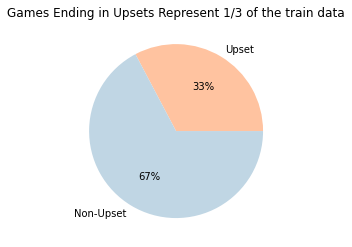

In [3]:
# get pie chart upsets
e.get_pie_upsets(train)

* About 1/3 of the games in the training data will end in upset

## Dose first move advantage effect upsets?

* In chess, traditionally, the player moving the white pieces makes the first move

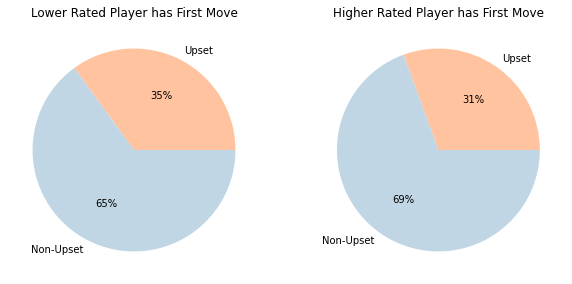

In [4]:
# get pie chart Lower Rated White
e.get_pies_white(train)

* Upset Percentage is 4% higher in games where the lower rated player makes the first move.

**I will now use a chi-square test to investigate whether 'Upset' and "Lower Rated White" are dependant on one another** 
* I will use a confidance interval of 95% 
* The resulting alpha is .05<br>

**Ho: "Upset" and "Lower Rated White" are independant of one another.**<br>
**Ha: "Upset" and "Lower Rated White" are dependant on one another.**

In [5]:
# get chi-square test
e.get_chi_white(train)

chi^2 = 24.9953
p     = 0.0000


**The P value is grater than our alpha. Therefore, we have evidence to support that "Upset" and "Lower Rated White" are dependant on one another. Based on this, and the 4% difference in upsets, observed in the train data, I believe that using the "Lower Rated White" feature in modeling will likely have a small positive impact on the model's accuracy.**

## Does a game being rated effect upsets?

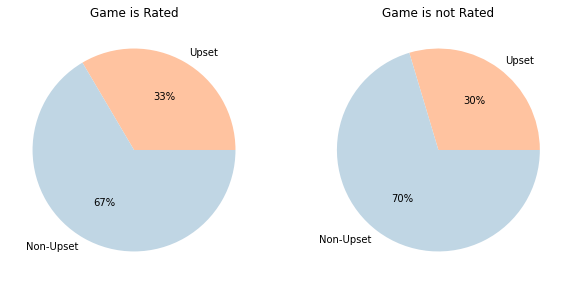

In [6]:
# get pie charts
e.get_pie_rated(train)

* Upset percentage is 3% higher in games that are rated

**I will now use a chi-square test to investigate weather "Upset" and "Rated" are dependant on one another.**
* I will use a confidance interval of 95% 
* The resulting alpha is .05<br>

**Ho: "Game is rated" and "Game ended in Upset" are independant of one another.** <br>
**Ha: "Game is rated" and "Game ended in Upset" are dependant of one another.**

In [7]:
# get chi-square results
e.get_chi_rated(train)

chi^2 = 11.7329
p     = 0.0006


**The P value is less than our alpha. Therefore, we have evidence supporting that "Upset" and "Rated" are dependant on one another. Based on this and the 3% difference in upsets, observed in the train data, I believe that using the "Rated" feature in modeling will likely have a small positive impact on the model's accuracy.**

## Does player rating have an effect on upsets?
I will examine two subquestions to answer this question.

### 1) Does game rating (The average rating of both players in a game) have an effect on upsets? 

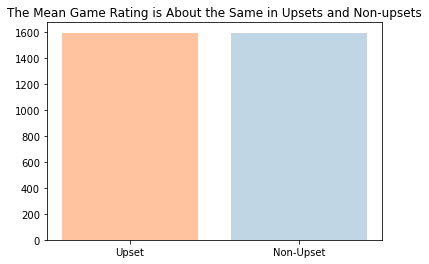

In [8]:
# get bar chart
e.get_game_rating(train)

* The average game rating for upsets is very similer to the average rating for non-upsets

**Because the average game rating for games that end in upsets is very similer to the average game rating of games that do not end in upsets, it is not likely that "Game Rating" will be a useful feature to model on.**

### 2) Does difference in player rating have an effect on upsets?

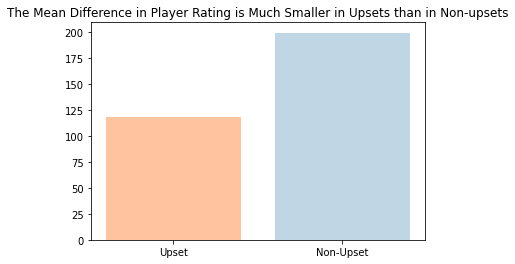

In [9]:
# get bar chart
e.ave_diff_rating(train)

* The average difference in player rating is 82 points lower in games ending in upset.

**I will now do a T-test to test for a significant difference between the mean difference in player rating of games ending in upset and the mean difference in player rating of games ending in non-upset.**

* I will use a confidence interval of 95%
* The resulting alpha is .05

**HO: The mean difference in player rating of games ending in upset is not significantly differint from the mean difference in player rating of games not ending in an upset.** <br>
**HA: The mean difference in player rating of games ending in upset is significantly differint from the mean difference in player rating of games not ending in an upset.**

In [10]:
# get T-test result
e.get_t_rating_diff(train)

t = -23.2930
p = 0.0000


**The p-value is less than the alpha. Therefore, we have evidence to support that the mean rating difference of players in games ending in upset is significantly differint from the mean rating difference of players in games that end in non-upsets. Based on this, and the 82 point difference in means, observed in the train data, I believe that using "Rating Difference" during modeling will provide a moderate improvement in the model's sccuracy.** 

## Does time block effect upsets?

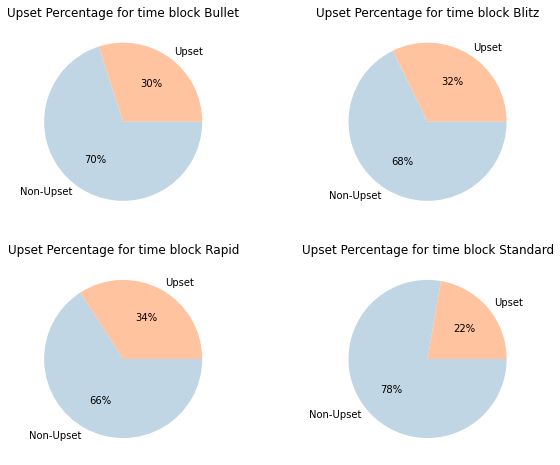

In [11]:
# Get pie charts
e.get_pie_time(train)

* In time control groups where time is very limited, such as Bullet, Blitz, and Rapid games upset percentage ranges from 30 to 34%.
* In Standard, where time is more plentaful, upsets drop to 22%. 

**I will now perform a chi-square test to determin if "Upset" and "Time control Group" are independant.**
* I will use a confidence interval of 95%
* The resulting alpha is .05

**Ho: "Games ending in Upset" and "Time Control Group" are independant of one another.** <br>
**Ha: "Games ending in Upset" and "Time Control Group" are dependant on one another.**

In [12]:
# get chi-square test
e.get_chi_time(train)

chi^2 = 11.5701
p     = 0.0209


**The p-value is less than the alpha. Therefore, we have evidence to support that "Time Control Group" and "Games ending in upset" are dependant on one another. Based on this, and the differences in upset percentages amoung the differint time groups, I belive that Time Control Group will be usefull in modeling once the different values have been encoded.**

# Does Opening effect upsets?

* There are 1236 unique openings identified in the training data
* This is too many for a thorough examination of each
* I will examin the top ten, by popularity

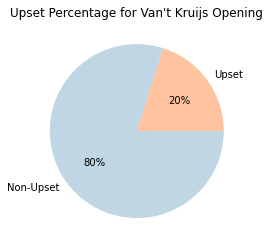

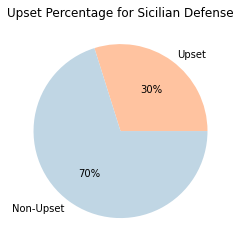

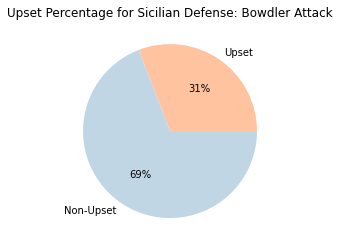

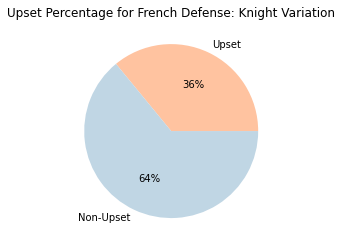

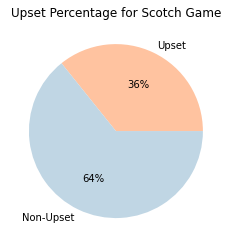

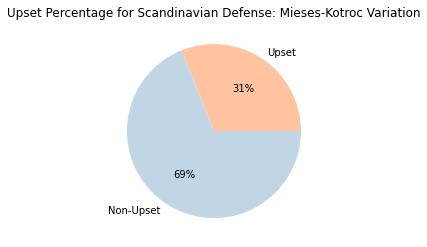

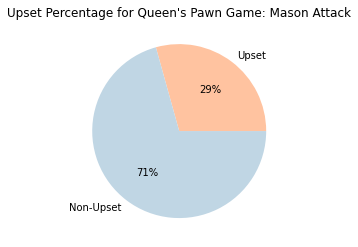

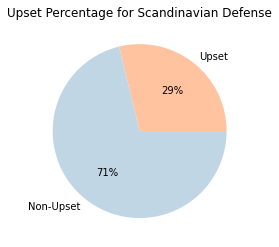

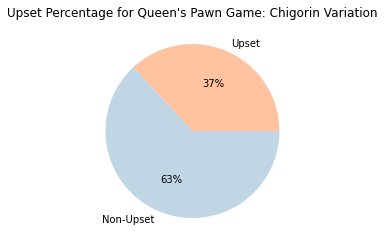

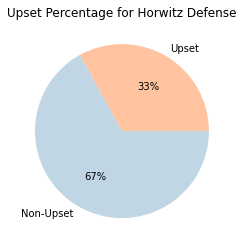

In [13]:
# get upset distributions of top ten most populer openings
e.get_pie_open(train)

* Percentage of upsets range from 20 - 37 percent 

**I will now run a chi-square test to see if "Opening" and "Upset" are dependant on one another.**
* I will use a confidence interval of 95%
* The resulting alpha is .05

**Ho: "Upset" and "Opening Name" are independant of one another.** <br>
**Ha: "Upset" and "Opening Name" are dependant on one another.**

In [14]:
# get chi-square results
e.get_chi_open(train)

chi^2 = 1350.4134
p     = 0.0117


**P is less than the Alpha. Therfore, we have evidence to support "Opening Name" and "Upset" are dependant on one another. Based on this, and the large range of upset percentages observed amoung openings in the train data, I belive that opening is a driver of upsets. However, given the sheer number of opening it is possible that, once encoded, the addition of +1200 may do more harm to the model than good. For now we will continue with this feature into modeling.**

# Exploration Summery

* "Lower Rated White" and "Rated" were each found to be dependant with "Upset" though the amount of influance each has is likely to be very weak
* "Rating Difference" was found to be dependant with "upsets."
* "Time Control group" was found to be dependant with "upsets." Being in the standard time control or not seemed to have a particularly strong influance.
* "opening" was found to be dependant with "upsets." Upset percentage ranged from 20-37%.
* The mean difference in player rating in games that are upsets were found to be significantly different from the mean difference inplayer rating in games that are not upsets
</br>
* No evidence was found to support the idea that the "average player rating" is a driver of upsets
<br>

# Features I am Moving to Modeling With
* "Lower Rated White" (small difference in upset percentage, but dependance is statistically significant)
* "Rated" (small difference in upset percentage, but dependance is statistically significant)
* "Time Control Group" (moderate difference in upset percentage, and dependance is statistically significant)
* "Opening" (moderate difference in upset percentage, dependance is statistically significant, Lots of features to encode)
* "Rating Difference" (Large difference in rating observed, and difference is significant)

# Modeling Prep



**Steps to prepare for Modeling:**

* Dropped features not being used in modeling
* Split train, validate, and split into X and y dataframes
* Scaled continuous variable
* Encoded boolean variables
* converted 'Upset' to catagorical variable with values upset or non-upset

In [15]:
# prep data for modeling
train_X, validate_X, test_X, train_y, validate_y, test_y = m.model_prep(train,validate,test)

# Modeling

* I will use accuracy as my evaluation metric  
* non-upsets makeup 67% of the data
* by guessing non-upset for every game one could achieve an accuracy of 67%
* 67% will be the baseline accuracy I use for this project
* I will be looking at four different model types on train and validate data
* The model that performs the best will then be evaluated on test data 

## Decision Tree

In [16]:
# get decision tree results
m.get_tree(train_X, validate_X, train_y, validate_y)

Accuracy of Decision Tree on train data is 0.6760149572649573
Accuracy of Decision Tree on validate data is 0.6724137931034483


* Deceision Tree accuracy is about equal to the baseline

## Random Forest

In [17]:
# get random forest results
m.get_forest(train_X, validate_X, train_y, validate_y)

Accuracy of Random Forest on train is 0.6726317663817664
Accuracy of Random Forest on validate is 0.6726215205650187


* Random Forest accuracy is about equal to the baseline

## Logistic Regression

In [18]:
# get logistic regression results
m.get_reg(train_X, validate_X, train_y, validate_y)

Accuracy of Logistic Regression on train is 0.7026353276353277
Accuracy of Logistic Regression on validate is 0.6560033236393851


* Logistic regression accuracy is better than baseline on train, and worse thatn baseline on validate
* It is likely over-fit


## KNN

In [ ]:
# get knn results
m.get_knn(train_X, validate_X, train_y, validate_y)

* Logistic regression accuracy is better than baseline on train, and worse thatn baseline on validate
* It is likely over-fit

# Compairing Models

* All models perform at or below baseline
* The two models that perform at baseline are Decision Tree and Random Forest
* Because both are within rounding error of one another in terms of accuracy
* I will proceed with the model that requiers the least amount of processing to run
* I will proceed to test with a Decision Tree Model

# Decision Tree on Test

In [ ]:
# get test results for final model
m.get_tree_test(train_X, test_X, train_y, test_y)

### Modeling Summery

* Decision Tree and Random Rorest models had an accuracy of about the same as the baseline
* Logistic Regression and KNN models out performed the baseline accuracy on train data, but the data was overfit leading the models having a worse than baseline accuracy on validate data
* A Decision Tree was selected as the final model and had an accuracy of 67% which is about equal to the baseline accuracy

# Conclusions

### Exploration

* Upsets in chess occur in about 1/3 of games
* Games in which the lower rated player makes the first move, and games that are rated have a slightly higher chance of ending in an upset 
* Games ending in upset have a much lower mean difference in player rating than games not ending in upset
* Games using shorter time control, such as Bullet, Blitz, and Rapid games, have an upset percentage that closely mirrors the overall upset percentage ranging from 30-34% while standard games have a much lower upset percentage at 22%
* Looking at the top 10 openings in terms of frequency in the data set we can conclude that a given opening does affect the likelihood of a game ending in an upset. Upset percentages very by opening from 20-39%
* The average rating of players in a game has no provable effect on the chance of that game ending in upset

### Modeling

**All of the models failed to outperform the baseline. Possible reasons and solutions include:**

* “Rated” and “lower rated white” each only accounted for a small difference in the percentage of upsets

* Time Control group had one outlier, in terms of percentage of upsets, which was standard. The values of each of the other time control groups were much closer together. Perhaps modeling only on this time controle would remove noise from the model.

* While “Opening Name” seemed to be a significant driver of upsets. It contains 1200+ values, that once encoded would adds an overwhilming number of features to the model. The additional noise this would add may have done more harm than good to the model. 

* Finally the values in “Opening Name” seem to include a major opening name along with variations of those openings. Creating clusters of all the variations of each opening may result in a more manageable number of features.   

**Should I have ocation to revisit this project I would like to try the following:**

* Cluster together opening variants in "Opening Name" to reduce the number of features input into the model
* Run the models without "Opening Name" to see there is any improvement made by just removing the additional noise.
* Look for other ways to describe "Opening Name" Such as by popularity of the opening or average rating of players playing that opening